In [1]:
import os
os.chdir("..")
home_dir = os.getcwd()
os.chdir("src")
from sdhm import SDHM
from baumwelch import BaumWelch
from accesstracer import AccessTracer
os.chdir(home_dir)

import numpy as np
import pandas as pd
import scipy.stats as st
import numpy.random as rd
import matplotlib.pyplot as plt
from IPython.display import display
plt.style.use("ggplot")

%matplotlib inline

# Access Tracer

1. 隠れマルコフモデルの混合分布による行動モデリング
2. 複数の混合隠れマルコフモデルのオンライン忘却型学習
3. 動的モデル選択による最適混合数の決定
4. スコアリング

## データ生成

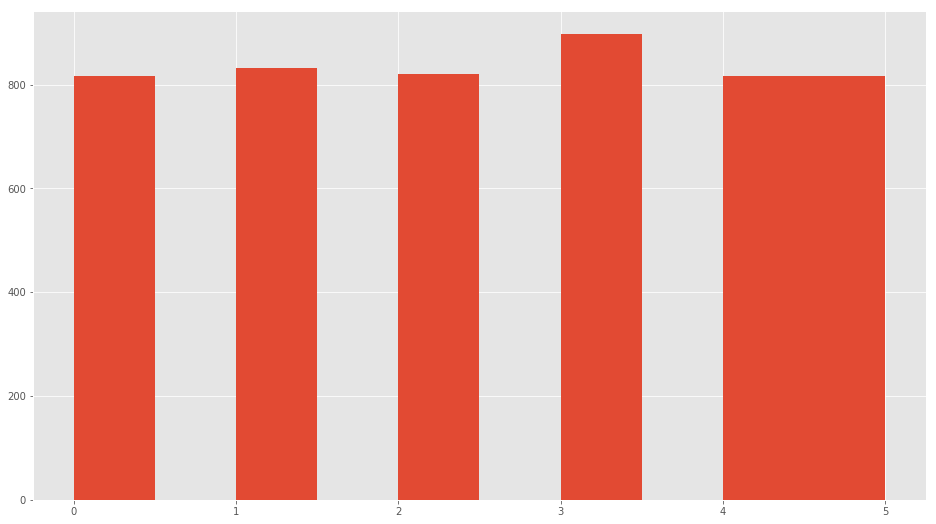

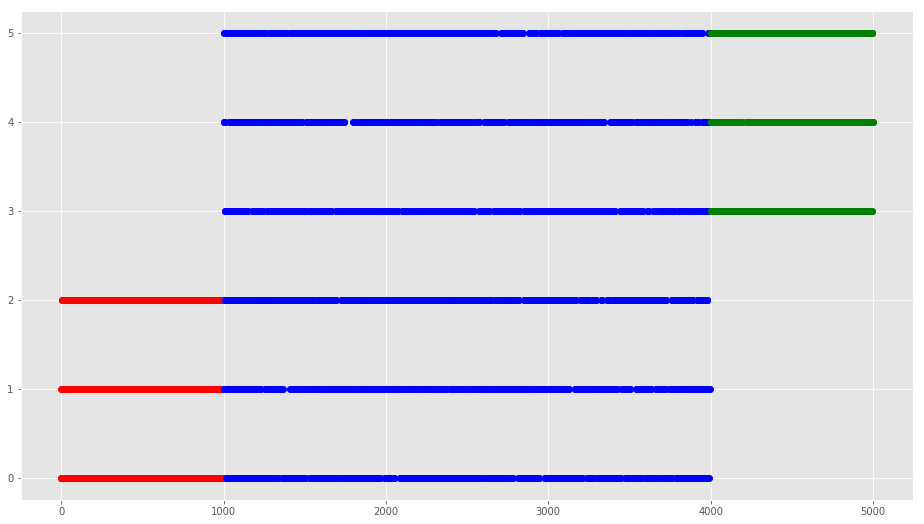

In [2]:
rd.seed(0)

dice1 = [0, 1, 2, 3, 4, 5]
dice2 = [0, 1, 2]
dice3 = [3, 4, 5]

y1 = rd.choice(dice2, 1000)
flag1 = np.array([2 for i in range(1000)])
y2 = rd.choice(dice1, 3000)
flag2 = np.array([1 for i in range(3000)])
y3 = rd.choice(dice3, 1000)
flag3 = np.array([3 for i in range(1000)])

y = np.concatenate([y1, y2, y3])
flag = np.concatenate([flag1, flag2, flag3])
data = np.concatenate([y[:, np.newaxis], flag[:, np.newaxis]], axis=1)
org_data = pd.DataFrame(data)

plt.figure(figsize=(16, 9))
plt.hist(org_data[0])
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(org_data.loc[org_data[1]==2][0], "o", c="r")
plt.plot(org_data.loc[org_data[1]==1][0], "o", c="b")
plt.plot(org_data.loc[org_data[1]==3][0], "o", c="g")
plt.show()

In [3]:
window_size = 5
y = np.array([np.array(org_data[0][i:i+window_size]) for i in range(0, org_data.shape[0], 5)])

In [4]:
y

array([[0, 1, 0, 1, 1],
       [2, 0, 2, 0, 0],
       [0, 2, 1, 2, 2],
       ..., 
       [4, 5, 4, 3, 4],
       [3, 5, 3, 5, 5],
       [3, 5, 5, 4, 4]])

## SDHM

In [5]:
# Given
r = 0.1 # 忘却パラメータ 0<r<1
nu = 0.1 # 推定係数
K = 3 # 混合数
n = 1 # HMMの次数
M = y.shape[0] # データ数
Tj = y.shape[1] # セッションの長さ
N1 = 3
N2 = 6

In [6]:
ac = AccessTracer(r, nu, K, Tj, N1, N2, n=1)

In [7]:
ac.all_update(y)

In [8]:
df = pd.DataFrame(y, columns=["y%s" % i for i in range(1, Tj+1)])
df["N_K"] = ac.N_K
df["S_A"] = ac.S_A

display(df.head())

,y1,y2,y3,y4,y5,N_K,S_A
0,0,1,0,1,1,2.0,1.440689
1,2,0,2,0,0,2.0,1.712459
2,0,2,1,2,2,2.0,1.686529
3,0,1,1,1,1,2.0,1.471382
4,0,1,0,0,1,2.0,1.380122


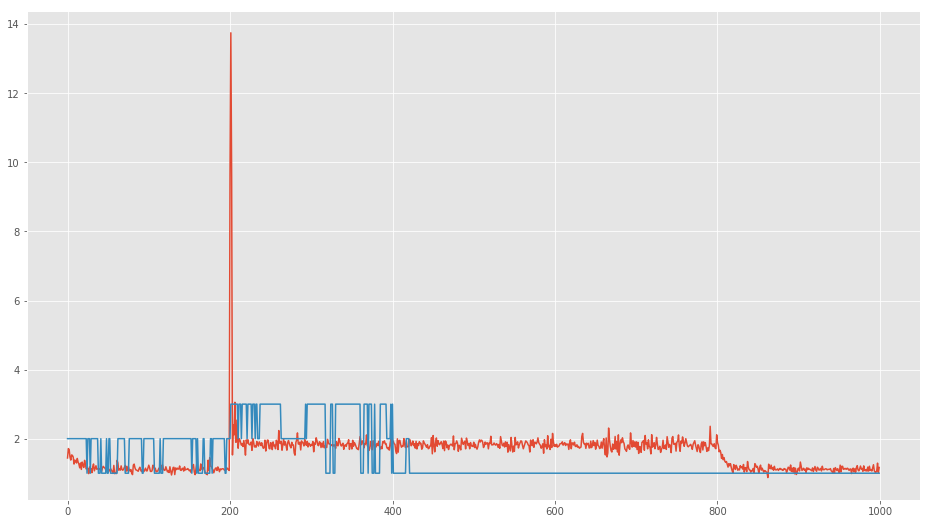

In [9]:
plt.figure(figsize=(16, 9))
plt.plot(df.S_A)
plt.plot(df.N_K)

## 日経平均株価にAccessTracerを適用

In [95]:
org_df = pd.read_csv("data/nikkei225_d.csv")

In [96]:
display(org_df.head())
display(org_df.tail())

,Date,Open,High,Low,Close
0,1986/01/04,13118.50,13142.33,13105.97,13136.87
1,1986/01/06,13129.05,13145.54,13053.22,13053.79
2,1986/01/07,13034.57,13037.68,12933.50,12991.24
3,1986/01/08,12997.74,13057.46,12996.80,13056.42
4,1986/01/09,13036.08,13062.26,12959.21,13034.19


,Date,Open,High,Low,Close
7708,2016/12/26,19394.41,19432.48,19385.94,19396.64
7709,2016/12/27,19353.43,19478.58,19352.06,19403.06
7710,2016/12/28,19392.11,19442.13,19364.73,19401.72
7711,2016/12/29,19301.04,19301.04,19092.22,19145.14
7712,2016/12/30,18997.68,19176.81,18991.59,19114.37


In [97]:
org_df_diff = org_df.iloc[:, 1:].diff()
org_df_diff = org_df_diff.dropna()

In [98]:
flag = []
for i, j in zip(org_df.Close[1:], org_df_diff.Close):
    if j/i >= 0.05:
        flag.append(6)
    elif j/i >= 0.03:
        flag.append(5)
    elif j/i >= 0.01:
        flag.append(4)
    elif j/i >= -0.01:
        flag.append(3)
    elif j/i >= -0.03:
        flag.append(2)
    elif j/i >= -0.05:
        flag.append(1)
    else:
        flag.append(0)

In [99]:
org_df = org_df[1:]
org_df["flag"] = flag
org_df = org_df[:-2]

In [100]:
window_size = 5
y = np.array([np.array(org_df.flag.iloc[i: i+window_size]) for i in range(0, org_df.shape[0], window_size)])

In [107]:
# Given
r = 0.1 # 忘却パラメータ 0<r<1
nu = 0.1 # 推定係数
K = 3 # 混合数
n = 1 # HMMの次数
M = y.shape[0] # データ数
Tj = y.shape[1] # セッションの長さ
N1 = 3
N2 = 7

In [108]:
ac = AccessTracer(r, nu, K, Tj, N1, N2, n=1)

In [109]:
ac.all_update(y)

In [110]:
df = pd.DataFrame(y, columns=["y%s" % i for i in range(1, Tj+1)])
df["N_K"] = ac.N_K
df["S_A"] = ac.S_A

display(df.head())
display(df.describe())

,y1,y2,y3,y4,y5,N_K,S_A
0,3,3,3,3,3,2.0,1.620287
1,3,3,3,3,3,1.0,1.051525
2,3,3,3,3,3,1.0,0.833078
3,3,3,3,3,3,1.0,0.680730
4,3,3,3,3,3,1.0,0.567717


,y1,y2,y3,y4,y5,N_K,S_A
count,1542.000000,1542.000000,1542.000000,1542.000000,1542.000000,1542.000000,1542.000000
mean,3.002594,2.957847,2.996109,3.028534,2.981193,1.886511,1.134707
std,0.752236,0.754076,0.758245,0.779667,0.742890,0.317292,0.804322
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.021651
25%,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,0.728181
50%,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,1.024347
75%,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,1.337692
max,6.000000,6.000000,6.000000,6.000000,6.000000,2.000000,9.418073


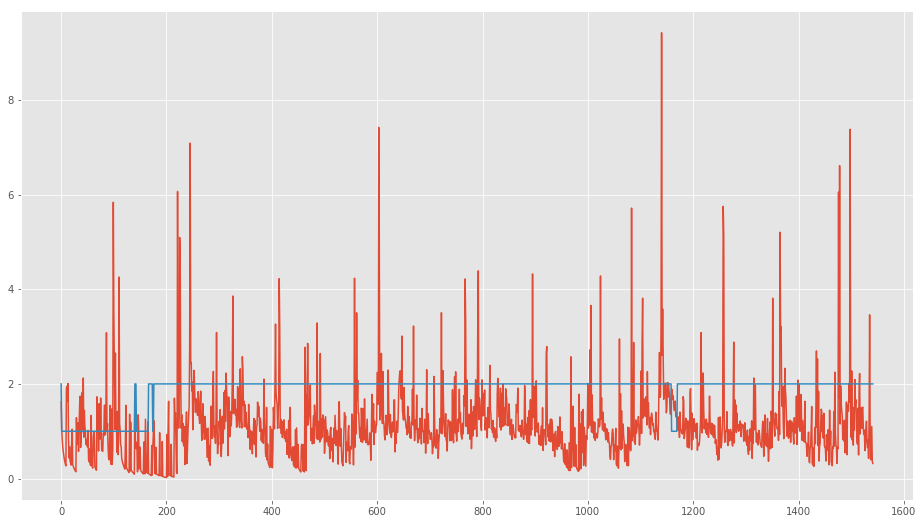

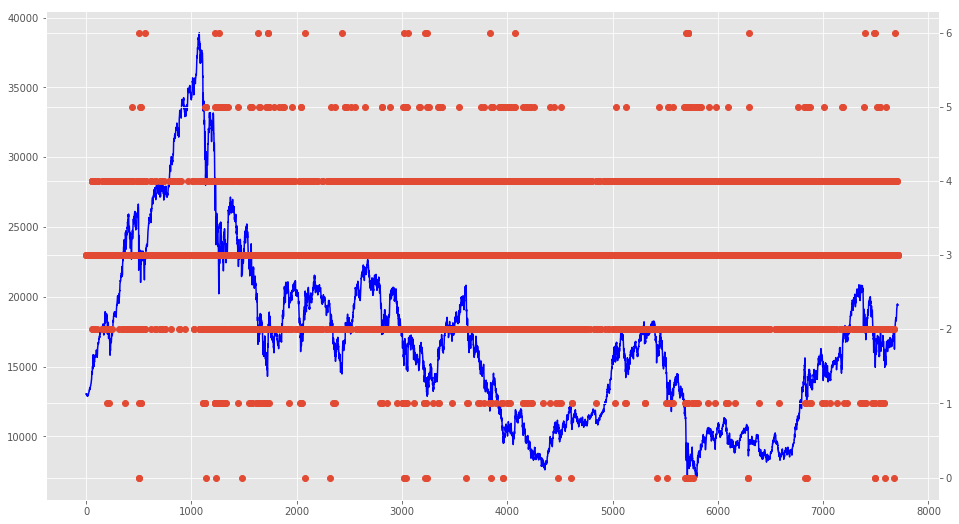

In [117]:
plt.figure(figsize=(16, 9))
plt.plot(df.S_A)
plt.plot(df.N_K)

fig, ax1 = plt.subplots(figsize=(16, 9))
 
# ax1とax2を関連させる
ax2 = ax1.twinx()
 
# それぞれのaxesオブジェクトのlines属性にLine2Dオブジェクトを追加
ax1.plot(org_df.Close,color="b")

ax2.plot(org_df.flag, "o")